In [1]:
import numpy as np
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import keras.datasets.fashion_mnist as fashion_mnist
import tensorflow as tf
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [3]:
x_train.shape

(60000, 28, 28)

In [ ]:
x_test.shape

(10000, 28, 28)

In [ ]:
y_test.shape

(10000,)

In [ ]:
y_train.shape

(60000,)

In [ ]:
x_test.shape

(10000, 84, 84, 9)

In [ ]:
x_train = np.expand_dims(x_train, axis=-1)
x_train = tf.image.resize(x_train, [84,84]).numpy()
#x_train = np.repeat(x_train, 3, axis=3)
x_test = np.expand_dims(x_test, axis=-1)
x_test = tf.image.resize(x_test, [84,84]).numpy()
#x_test = np.repeat(x_test, 3, axis=3)
y_train = y_train.astype('int')
y_test = y_test.astype('int')

print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

Training (60000, 84, 84, 1) 255.0
Testing (10000, 84, 84, 1) 255.0


In [ ]:
# reorganize by groups
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [ ]:
def gen_random_batch(in_groups, batch_halfsize = 8):
  out_img_a, out_img_b, out_score = [], [], []
  all_groups = list(range(len(in_groups)))
  for match_group in [True, False]:
    group_idx = np.random.choice(all_groups, size = batch_halfsize)
    out_img_a += [in_groups[c_idx]
[np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]

    if match_group:
      b_group_idx = group_idx
      out_score += [1]*batch_halfsize
    else:
      # anything but the same group
      non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx]
      b_group_idx = non_group_idx
      out_score += [0]*batch_halfsize
    out_img_b += [in_groups[c_idx]
[np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
  return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

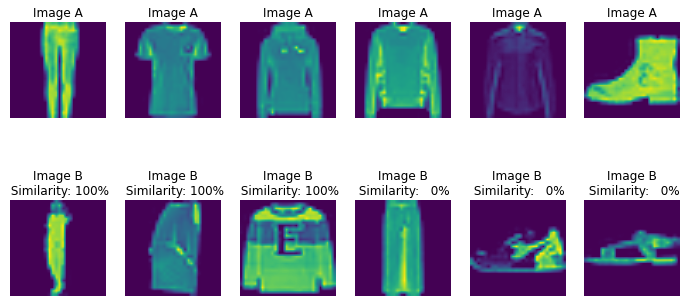

In [ ]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
  ax1.imshow(c_a[:,:,0])
  ax1.set_title('Image A')
  ax1.axis('off')
  ax2.imshow(c_b[:,:,0])
  ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
  ax2.axis('off')

In [ ]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.layers import concatenate
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout, AveragePooling2D, GlobalAveragePooling2D

In [ ]:
base_model = InceptionResNetV2(
    weights=None,
    include_top=False,
    input_shape=(84, 84, 1),
    classes=10
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(36, activation='relu')(x)
model = Model(inputs=base_model.input, outputs=predictions)


model.summary()


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 84, 84, 1)]  0           []                               
                                                                                                  
 conv2d_2030 (Conv2D)           (None, 41, 41, 32)   288         ['input_11[0][0]']               
                                                                                                  
 batch_normalization_2042 (Batc  (None, 41, 41, 32)  96          ['conv2d_2030[0][0]']            
 hNormalization)                                                                                  
                                                                                                  
 activation_2042 (Activation)   (None, 41, 41, 32)   0           ['batch_normalization_2042[

In [ ]:
from keras.layers import concatenate
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout

img_a_in = Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = Input(shape = x_train.shape[1:], name = 'ImageB_Input')
img_a_feat = model(img_a_in)
img_b_feat = model(img_b_in)
combined_features = concatenate([img_a_feat, img_b_feat], name ='merge_features')
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = Model(inputs = [img_a_in, img_b_in], outputs=[combined_features], name = 'Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 84, 84, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 84, 84, 1)]  0           []                               
                                                                                                  
 model_7 (Functional)           (None, 36)           55946948    ['ImageA_Input[0][0]',           
                                                                  'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 72)           0           ['model_7[0][0]', 

In [ ]:
# setup the optimization process
similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['mae'])

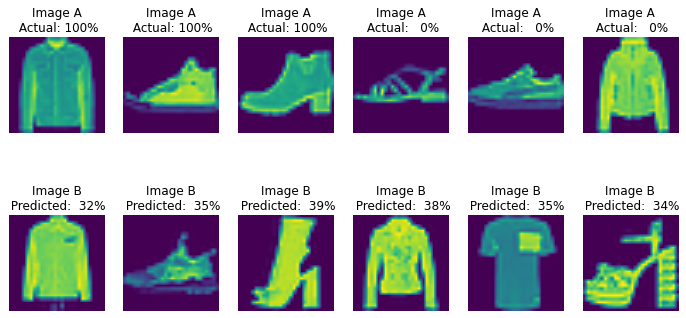

In [ ]:
def show_model_output(nb_examples = 3):
  pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
  pred_sim = similarity_model.predict([pv_a, pv_b])
  fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
  for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
    ax2.axis('off')
  return fig
# a completely untrained model
_ = show_model_output()

In [ ]:
# make a generator out of the data
def siam_gen(in_groups, batch_size = 32):
  while True:
    pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
    yield [pv_a, pv_b], pv_sim
# we want a constant validation group to have a frame of reference for model performance
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit_generator(siam_gen(train_groups),
                                            steps_per_epoch = 500,
                                            validation_data=([valid_a, valid_b], valid_sim),
                                            epochs = 10,
                                            verbose = True)

similarity_model.save('/model')

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


500/500 [==============================] - 364s 622ms/step - loss: 0.5586 - mae: 0.4042 - val_loss: 0.4540 - val_mae: 0.3331
Epoch 2/10
500/500 [==============================] - 292s 584ms/step - loss: 0.4346 - mae: 0.3153 - val_loss: 0.4126 - val_mae: 0.2802
Epoch 3/10
500/500 [==============================] - 292s 584ms/step - loss: 0.3937 - mae: 0.2761 - val_loss: 0.3768 - val_mae: 0.2540
Epoch 4/10
500/500 [==============================] - 293s 586ms/step - loss: 0.3671 - mae: 0.2479 - val_loss: 0.3464 - val_mae: 0.2305
Epoch 5/10
500/500 [==============================] - 292s 585ms/step - loss: 0.3558 - mae: 0.2350 - val_loss: 0.3605 - val_mae: 0.2216
Epoch 6/10
500/500 [==============================] - 292s 585ms/step - loss: 0.3307 - mae: 0.2169 - val_loss: 0.3433 - val_mae: 0.2111
Epoch 7/10
500/500 [==============================] - 292s 584ms/step - loss: 0.3297 - mae: 0.2108 - val_loss: 0.3300 - val_mae: 0.2112
Epoch 8/10
500/500 [==============================] - 291s 

INFO:tensorflow:Assets written to: /model/assets


INFO:tensorflow:Assets written to: /model/assets


In [ ]:
model.save('/model2')

INFO:tensorflow:Assets written to: /model2/assets


INFO:tensorflow:Assets written to: /model2/assets


In [ ]:
np.save('my_history.npy',loss_history.history)

In [ ]:
history=np.load('my_history.npy',allow_pickle='TRUE').item()

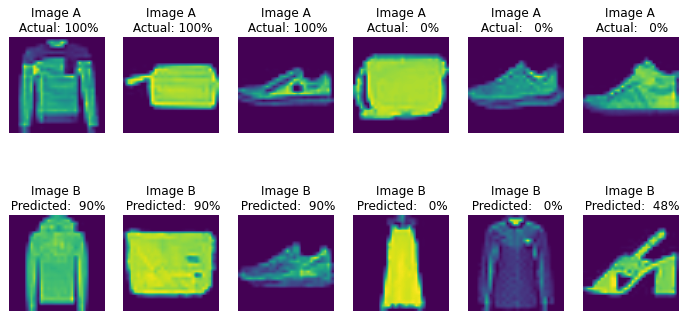

In [ ]:
_ = show_model_output()

In [ ]:
similarity_model.save('/model')

In [ ]:
t_shirt_vec = np.stack([train_groups[0][0]]*x_test.shape[0],0)
t_shirt_score = similarity_model.predict([t_shirt_vec, x_test], verbose = True, batch_size = 128)
ankle_boot_vec = np.stack([train_groups[-1][0]]*x_test.shape[0],0)
ankle_boot_score = similarity_model.predict([ankle_boot_vec, x_test], verbose = True, batch_size = 128)

79/79 [==============================] - 27s 346ms/step


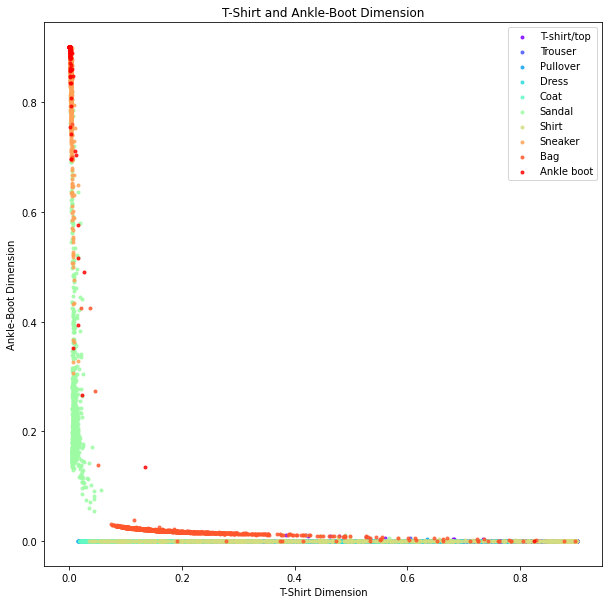

In [ ]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
  plt.scatter(t_shirt_score[np.where(y_test == c_group), 0],
                      ankle_boot_score[np.where(y_test == c_group), 0],
                      marker='.',
                      color=c_color,
                      linewidth='1',
                      alpha=0.8,
                      label=c_label)
plt.xlabel('T-Shirt Dimension')
plt.ylabel('Ankle-Boot Dimension')
plt.title('T-Shirt and Ankle-Boot Dimension')
plt.legend(loc='best')
plt.savefig('tshirt-boot-dist.png')
plt.show(block=False)

In [ ]:
x_test_features = model.predict(x_test, verbose = True, batch_size=128)

79/79 [==============================] - 18s 175ms/step


In [ ]:
%%time
from sklearn.manifold import TSNE
tsne_obj = TSNE(n_components=2,
        init='pca',
        random_state=101,
        method='barnes_hut',
        n_iter=500,
        verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 3.961s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 10.297607
[t-SNE] Computed conditional probabilities in 0.718s


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Iteration 50: error = 56.5217285, gradient norm = 0.0168297 (50 iterations in 5.313s)
[t-SNE] Iteration 100: error = 55.6350937, gradient norm = 0.0164633 (50 iterations in 4.576s)
[t-SNE] Iteration 150: error = 55.2299194, gradient norm = 0.0113210 (50 iterations in 4.400s)
[t-SNE] Iteration 200: error = 54.8532486, gradient norm = 0.0083112 (50 iterations in 4.231s)
[t-SNE] Iteration 250: error = 54.8411446, gradient norm = 0.0071184 (50 iterations in 4.176s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.841145
[t-SNE] Iteration 300: error = 1.0530300, gradient norm = 0.0007098 (50 iterations in 4.370s)
[t-SNE] Iteration 350: error = 0.9254783, gradient norm = 0.0003310 (50 iterations in 4.473s)
[t-SNE] Iteration 400: error = 0.8572422, gradient norm = 0.0002201 (50 iterations in 4.626s)
[t-SNE] Iteration 450: error = 0.8131356, gradient norm = 0.0001617 (50 iterations in 4.637s)
[t-SNE] Iteration 500: error = 0.7814258, gradient norm = 0.0001341 (50 

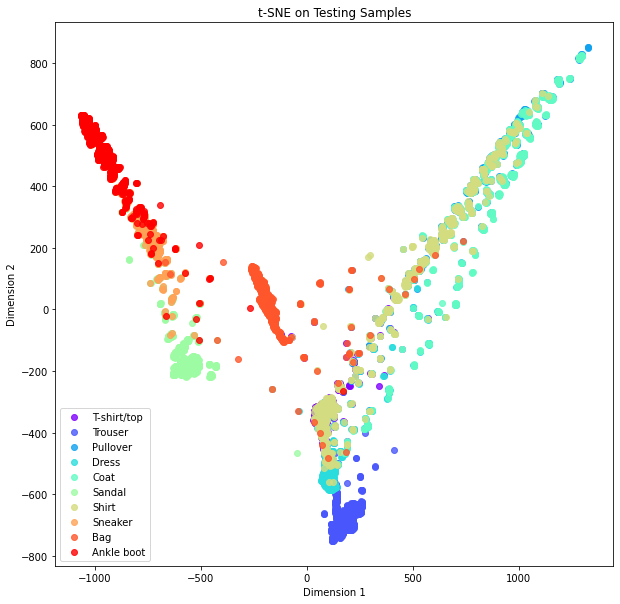

In [ ]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
  plt.scatter(tsne_features[np.where(y_test == c_group), 0],
              tsne_features[np.where(y_test == c_group), 1],
              marker='o',
              color=c_color,
              linewidth='1',
              alpha=0.8,
              label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)